<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/basic_deeplearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망(CNN)

이번 장의 주제는 합성곱 신경망입니다.  
 CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용되는데,   
 특히 이미지 인식 분야에서 딥러닝을 활용한 기법은 대부분 CNN을 기반으로 합니다.   
 이번장에서는 CNN의 매커니즘을 자세히 알아봅시다.

## 7.1 전체 구조
CNN도 지금까지와 같이 레고 블럭처럼 조합하여 만들 수 있습니다. 다만, 합성곱 계층과 풀링계층이 새롭게 등장합니다. 지금까지의 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있습니다. 이를 완전연결(Fully-Connected)이라고 하며, Affine 계층이라는 이름으로 구현했습니다. 완전연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층이 이어집니다.  
이러한 연결이 Conv-ReLU-(Pooling)을 바뀌었다고 생각하면 됩니다. 

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/ch07

/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/ch07


In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import *
import pickle
from collections import OrderedDict
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

In [4]:
# 합성곱 계층 구현하기
from common.util import im2col
x1 = np.random.rand(1, 3, 7, 7).round(2)
print(x1)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1)
print(col1.shape)

[[[[0.28 0.1  0.86 0.95 0.81 0.23 0.73]
   [0.6  0.35 0.14 0.29 0.57 0.78 0.73]
   [0.15 0.92 0.48 0.77 0.39 0.92 0.64]
   [0.02 0.19 0.6  0.46 0.85 0.21 0.37]
   [0.05 0.96 0.46 0.88 0.46 0.64 0.82]
   [0.53 0.25 1.   0.92 0.53 0.86 0.79]
   [0.74 0.94 0.01 0.08 0.33 0.21 0.73]]

  [[0.24 0.96 0.12 0.8  0.77 0.08 0.32]
   [0.21 0.48 0.38 0.69 0.32 0.51 0.1 ]
   [0.75 0.56 0.75 0.3  0.39 0.92 0.86]
   [0.17 0.84 0.56 0.29 0.11 0.41 0.59]
   [0.2  0.18 0.18 0.13 0.55 0.08 0.55]
   [0.28 0.95 0.26 0.91 0.61 0.28 0.29]
   [0.62 0.46 0.2  0.44 0.84 0.04 0.3 ]]

  [[0.25 0.85 0.19 0.02 0.49 0.47 0.08]
   [0.   0.62 0.89 0.18 0.87 0.55 0.44]
   [0.07 0.52 0.55 0.4  0.28 0.31 0.86]
   [0.66 0.14 0.65 0.49 0.89 0.04 0.64]
   [0.83 0.95 0.39 0.8  0.55 0.13 0.83]
   [0.66 0.15 0.92 0.53 0.1  0.45 0.52]
   [0.77 0.13 0.85 0.83 0.6  0.85 0.46]]]]
[[0.28 0.1  0.86 0.95 0.81 0.6  0.35 0.14 0.29 0.57 0.15 0.92 0.48 0.77
  0.39 0.02 0.19 0.6  0.46 0.85 0.05 0.96 0.46 0.88 0.46 0.24 0.96 0.12
  0.8  0.

In [5]:
x2 = np.random.rand(10, 3, 7, 7).round(2)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(90, 75)


In [6]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),  # 784
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()   # 순서가 있는 딕셔너리
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.3004467198782708
=== epoch:1, train acc:0.212, test acc:0.22 ===
train loss:2.2979979378763042
train loss:2.294436635135244
train loss:2.2889386669249223
train loss:2.278878215943522
train loss:2.2649665692519325
train loss:2.251646987507864
train loss:2.243584515498566
train loss:2.2184291359106094
train loss:2.1691368743387556
train loss:2.1728396514295545
train loss:2.1233183447042294
train loss:2.1117026799128062
train loss:2.083595183462589
train loss:2.024002374545422
train loss:1.9406015959597003
train loss:1.943162483284416
train loss:1.7849305760091132
train loss:1.7085430609734595
train loss:1.6756257877477845
train loss:1.6387422158815874
train loss:1.5577470426402646
train loss:1.4179124053445158
train loss:1.3953070262789118
train loss:1.3066014612830414
train loss:1.1484291063716814
train loss:1.0618136477293776
train loss:1.0230544843133864
train loss:0.9422544282579434
train loss:1.1007822771309914
train loss:0.8709967496800517
train loss:0.9418830343442502

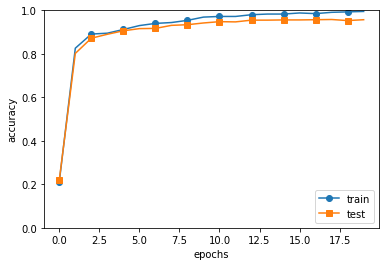

In [7]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

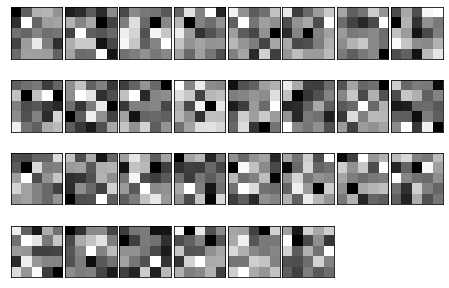

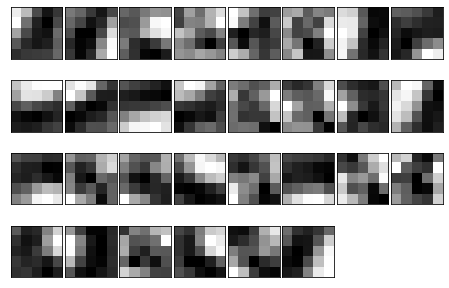

In [9]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])